<a href="https://colab.research.google.com/github/FokrulBhuiyan/Deep-learning-projects/blob/main/DLP_5_BERT_Driven_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
print(os.getcwd())
os.chdir(path=r"/content/drive/MyDrive/30 Days DL/DLP-5 BERT Driven Sentiment Classification")
print(os.getcwd())

/content
/content/drive/MyDrive/30 Days DL/DLP-5 BERT Driven Sentiment Classification


### Packages


In [3]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3


In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
import re
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from collections import defaultdict
import torch
from tqdm import tqdm
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from PIL import Image
NEW_COLOR_PALETTE = ["#FF6347", "#FF4500", "#FFD700", "#32CD32", "#8A2BE2", "#00FA9A"]

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette(NEW_COLOR_PALETTE))

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='transformers')
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

### Read Data

In [6]:
df=pd.read_csv("./dataset/apps_reviews/reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [7]:
wordcloud_mask=np.array(Image.open("./dataset/wordcloud-mask-collection/twitter.png"))


### Data Exploration

In [8]:
df.shape

(15746, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [10]:
df.isnull().sum()


,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,2213
at,0
replyContent,8379
repliedAt,8379
sortOrder,0


In [11]:
df.drop(columns=["userName","userImage","thumbsUpCount","reviewCreatedVersion","at","repliedAt", "sortOrder", "appId"], axis=1,inplace=True)
df.head()

,content,score,replyContent
0,Update: After getting a response from the deve...,1,"According to our TOS, and the term you have ag..."
1,Used it for a fair amount of time without any ...,1,It sounds like you logged in with a different ...
2,Your app sucks now!!!!! Used to be good but no...,1,This sounds odd! We are not aware of any issue...
3,"It seems OK, but very basic. Recurring tasks n...",1,We do offer this option as part of the Advance...
4,Absolutely worthless. This app runs a prohibit...,1,We're sorry you feel this way! 90% of the app ...


In [12]:
df.isnull().sum()


,0
content,0
score,0
replyContent,8379


In [13]:
df["text"]=df["content"]+" "+df["replyContent"]

In [14]:
df.head()

,content,score,replyContent,text
0,Update: After getting a response from the deve...,1,"According to our TOS, and the term you have ag...",Update: After getting a response from the deve...
1,Used it for a fair amount of time without any ...,1,It sounds like you logged in with a different ...,Used it for a fair amount of time without any ...
2,Your app sucks now!!!!! Used to be good but no...,1,This sounds odd! We are not aware of any issue...,Your app sucks now!!!!! Used to be good but no...
3,"It seems OK, but very basic. Recurring tasks n...",1,We do offer this option as part of the Advance...,"It seems OK, but very basic. Recurring tasks n..."
4,Absolutely worthless. This app runs a prohibit...,1,We're sorry you feel this way! 90% of the app ...,Absolutely worthless. This app runs a prohibit...


In [15]:
df.drop(columns=["content","replyContent"],axis=1,inplace=True)
df.head()

,score,text
0,1,Update: After getting a response from the deve...
1,1,Used it for a fair amount of time without any ...
2,1,Your app sucks now!!!!! Used to be good but no...
3,1,"It seems OK, but very basic. Recurring tasks n..."
4,1,Absolutely worthless. This app runs a prohibit...


In [16]:
df["text"][0]


"Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK. According to our TOS, and the term you have agreed to upon creating your free trial, after the 7 days, there is an automatic charge for the plan, unless you cancel prior to the renewal date. As you did not cancel the subscription in time, you were charged per this agreement."

In [17]:
df["score"].value_counts()


,count
score,
3,5042
5,2900
4,2776
1,2566
2,2462


<ipython-input-18-365db565dd0b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="score",data=df, palette=NEW_COLOR_PALETTE)
<ipython-input-18-365db565dd0b>:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(x="score",data=df, palette=NEW_COLOR_PALETTE)


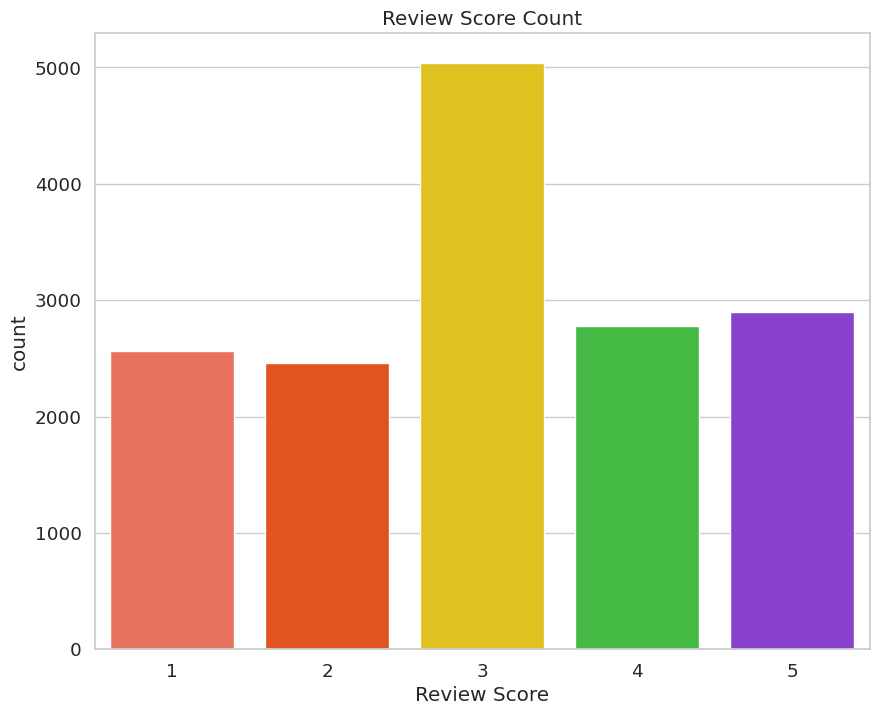

In [18]:
plt.figure(figsize=(10,8))
sns.countplot(x="score",data=df, palette=NEW_COLOR_PALETTE)
plt.xlabel("Review Score")
plt.title("Review Score Count")
plt.show()

###  Define a function to categorize the sentiment based on the score

In [19]:
def categorize_sentiment(score):
  if score == 3:
    return 'Neutral'
  elif score in [1, 2]:
    return 'Negative'
  elif score in [4, 5]:
    return 'Positive'

df['sentiment'] = df['score'].apply(categorize_sentiment)

In [20]:
df.head()


,score,text,sentiment
0,1,Update: After getting a response from the deve...,Negative
1,1,Used it for a fair amount of time without any ...,Negative
2,1,Your app sucks now!!!!! Used to be good but no...,Negative
3,1,"It seems OK, but very basic. Recurring tasks n...",Negative
4,1,Absolutely worthless. This app runs a prohibit...,Negative


<ipython-input-21-e61ee9538e2e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment",data=df,palette="gnuplot")


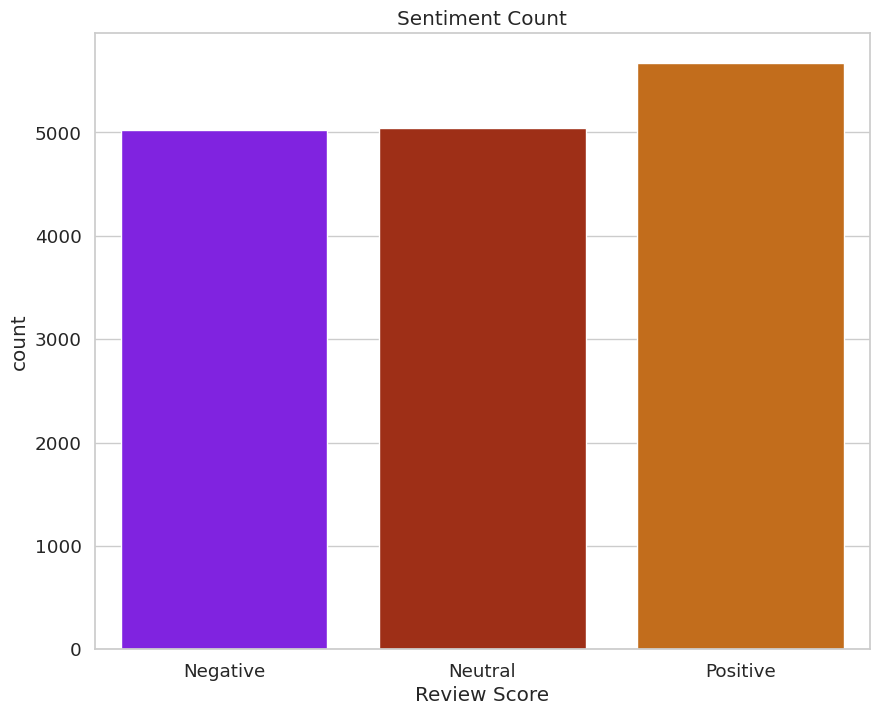

In [21]:
plt.figure(figsize=(10,8))
sns.countplot(x="sentiment",data=df,palette="gnuplot")
plt.xlabel("Review Score")
plt.title("Sentiment Count")
plt.show()

###  Clean Data

In [22]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [23]:
def clean_text(text):
  if isinstance(text, str):
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"u"\U0001F300-\U0001F5FF"u"\U0001F680-\U0001F6FF"u"\U0001F1E0-\U0001F1FF"u"\U00002702-\U000027B0"u"\U000024C2-\U0001F251""]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)
    text = re.sub(r"#.*", "", text)
    text = re.sub(r"/\*.*?\*/", "", text, flags=re.DOTALL)
    text = text.lower()

    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    text = ' '.join(tokens)

    return text
  else:
    return ""


In [24]:
df["text"]=df["text"].apply(clean_text)
df.head()

,score,text,sentiment
0,1,update getting response developer would change...,Negative
1,1,used fair amount time without problems suddenl...,Negative
2,1,app sucks used good update physically open clo...,Negative
3,1,seems ok basic recurring tasks need work actua...,Negative
4,1,absolutely worthless app runs prohibitively cl...,Negative


In [25]:
df.shape

(15746, 3)

In [26]:
df.drop(columns=["score"],axis=1,inplace=True)
df.shape

(15746, 2)

In [27]:
df.head()

,text,sentiment
0,update getting response developer would change...,Negative
1,used fair amount time without problems suddenl...,Negative
2,app sucks used good update physically open clo...,Negative
3,seems ok basic recurring tasks need work actua...,Negative
4,absolutely worthless app runs prohibitively cl...,Negative


### Negative/ Positive/ Neutral Text Length

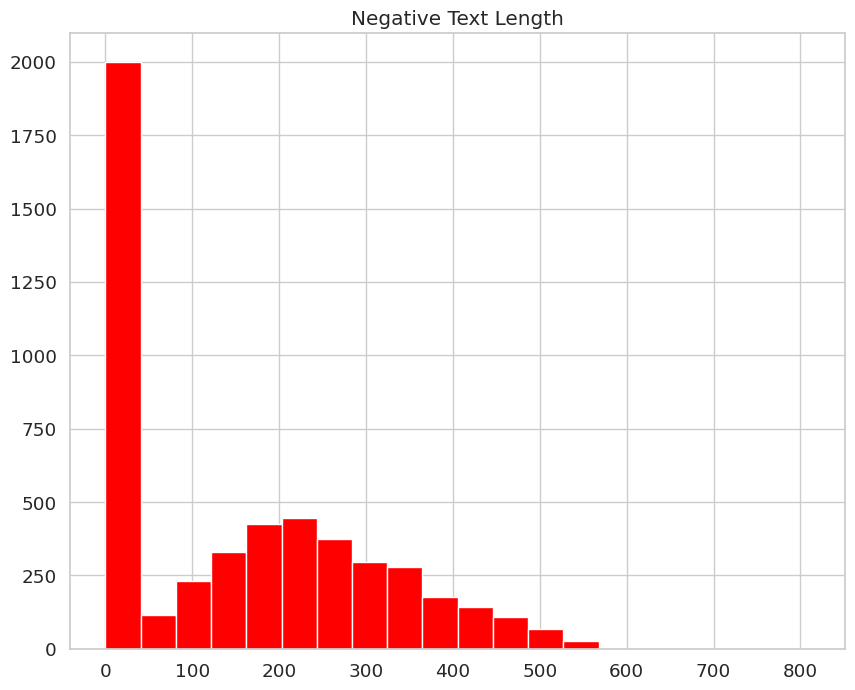

In [28]:
negative_text=df[df["sentiment"]=="Negative"]["text"].str.len()
plt.figure(figsize=(10,8))
plt.hist(negative_text, bins=20,label='Negative Text Length',color="red")
plt.title("Negative Text Length")
plt.show()


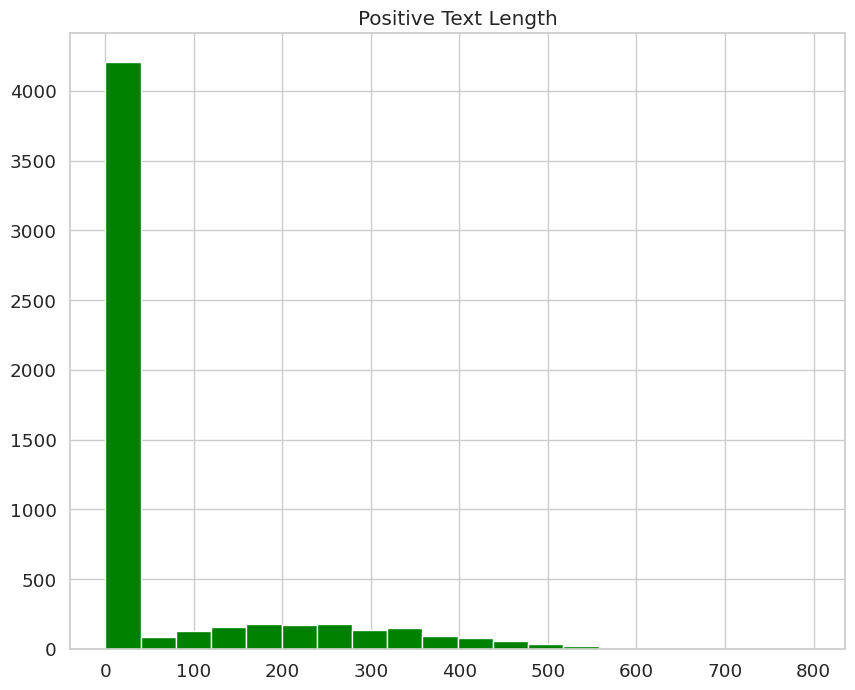

In [29]:
positive_text=df[df["sentiment"]=="Positive"]["text"].str.len()
plt.figure(figsize=(10,8))
plt.hist(positive_text, bins=20,label='Positive Text Length',color="green")
plt.title("Positive Text Length")
plt.show()


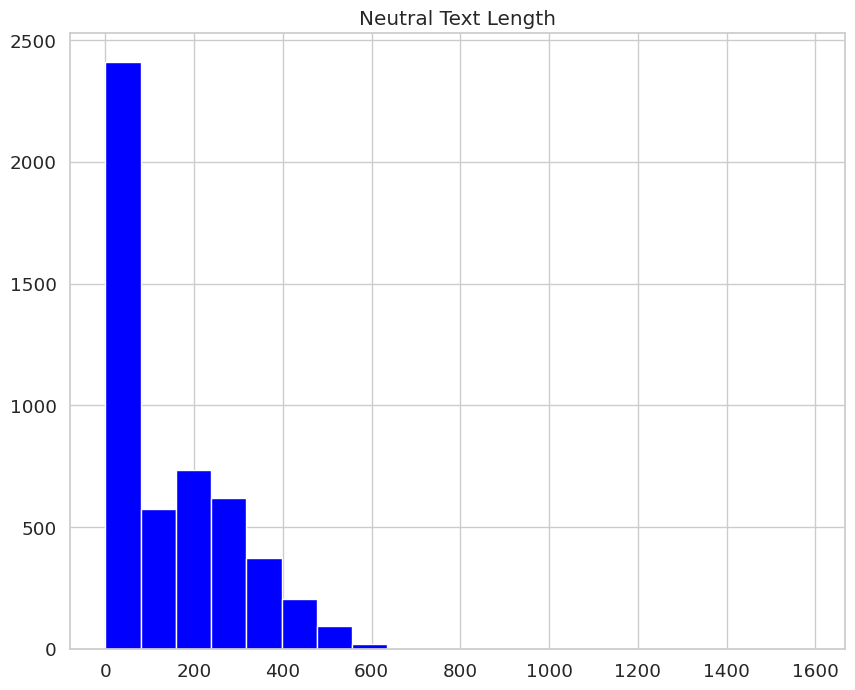

In [30]:
neutral_text=df[df["sentiment"]=="Neutral"]["text"].str.len()
plt.figure(figsize=(10,8))
plt.hist(neutral_text, bins=20,label='Neutral Text Length',color="blue")
plt.title("Neutral Text Length")
plt.show()

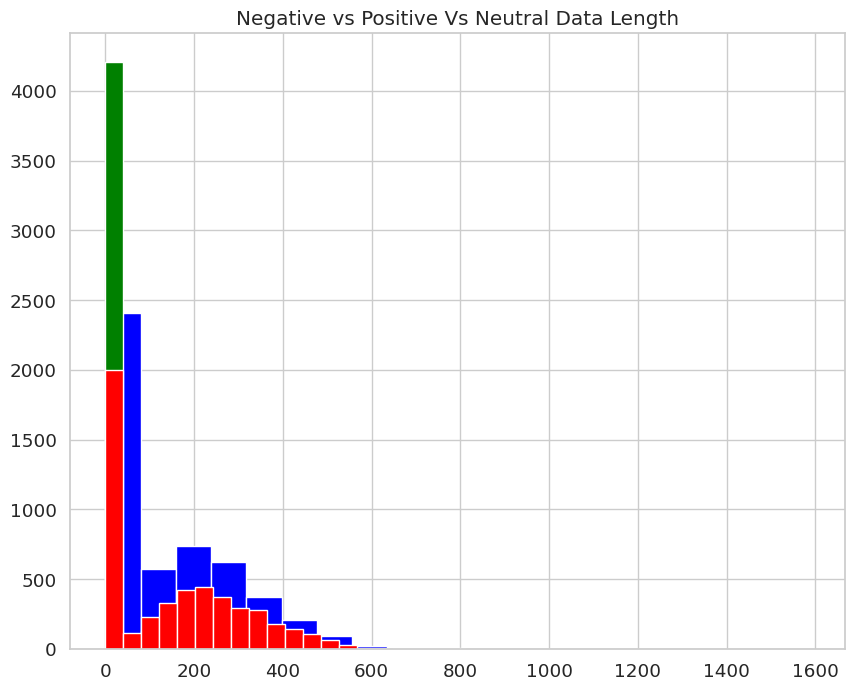

In [31]:
plt.figure(figsize=(10,8))
plt.hist(neutral_text, bins=20,label='Neutral Text Length',color="blue")
plt.hist(positive_text, bins=20,label='Positive Text Length',color="green")
plt.hist(negative_text, bins=20,label='Negative Text Length',color="red")
plt.title("Negative vs Positive Vs Neutral Data Length")
plt.show()


### Negative/ Positive/ Neutral Data WordCloud

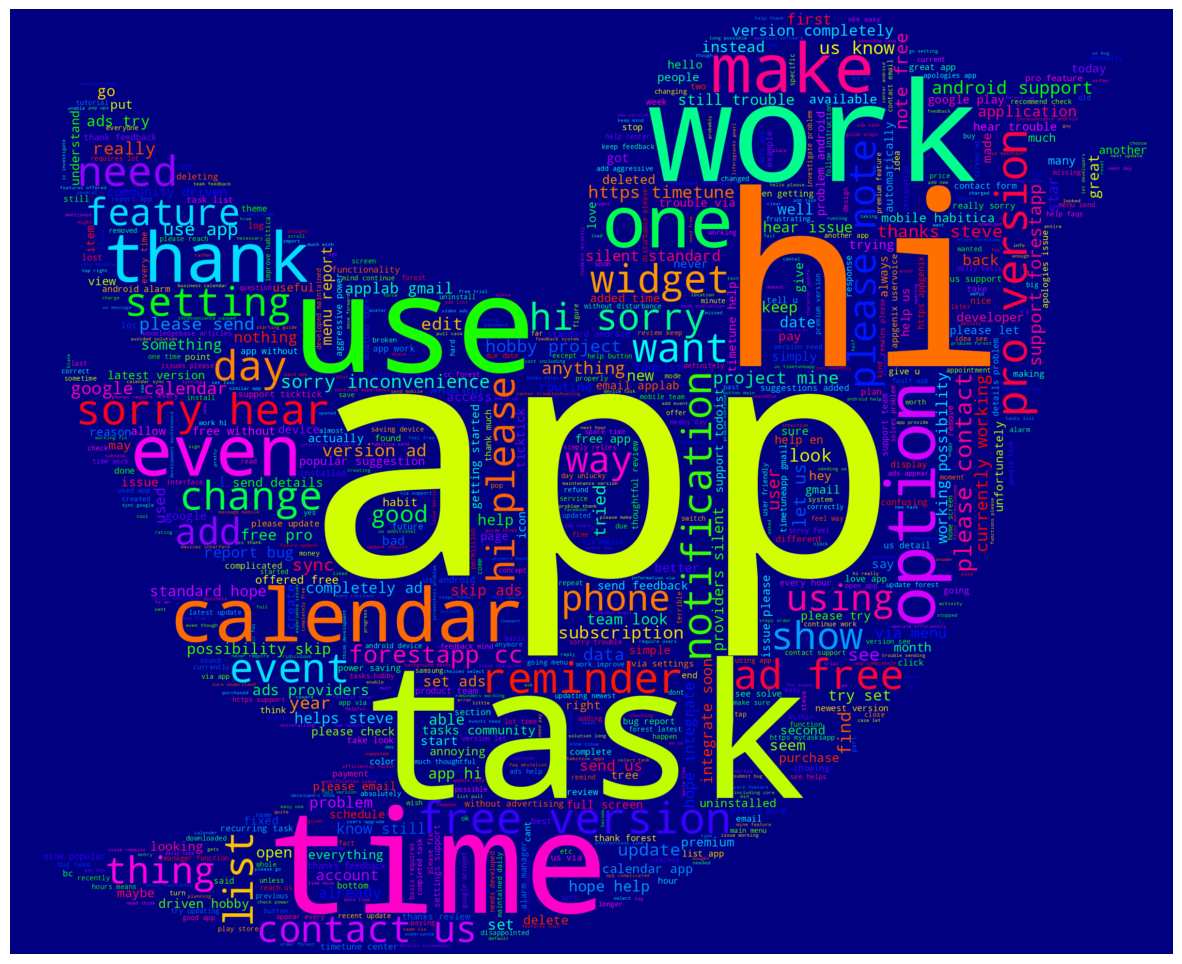

In [32]:
plt.figure(figsize=(15, 15))
negative_wordcloud = df[df["sentiment"] == "Negative"]
negative_text = " ".join(negative_wordcloud['text'].values.tolist())

wordcloud = WordCloud(width=800, height=800, stopwords=STOPWORDS,background_color='navy',
max_words=800, colormap="hsv", mask=wordcloud_mask).generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


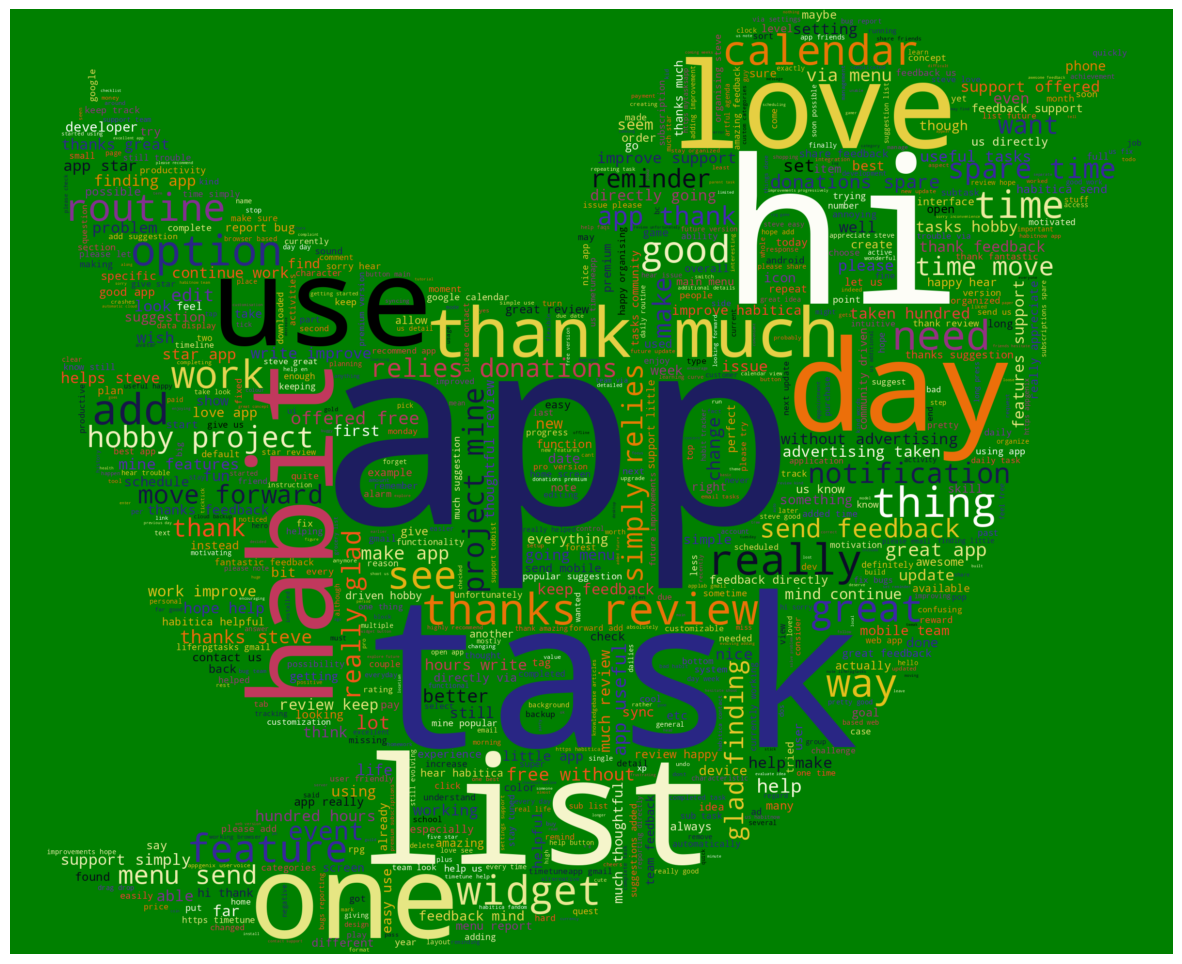

In [33]:
plt.figure(figsize=(15,15))
positive_wordcloud=df[df["sentiment"]=="Positive"]

positive_text=" ".join(positive_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS,background_color='green',max_words=800,colormap="CMRmap",mask=wordcloud_mask).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.show()


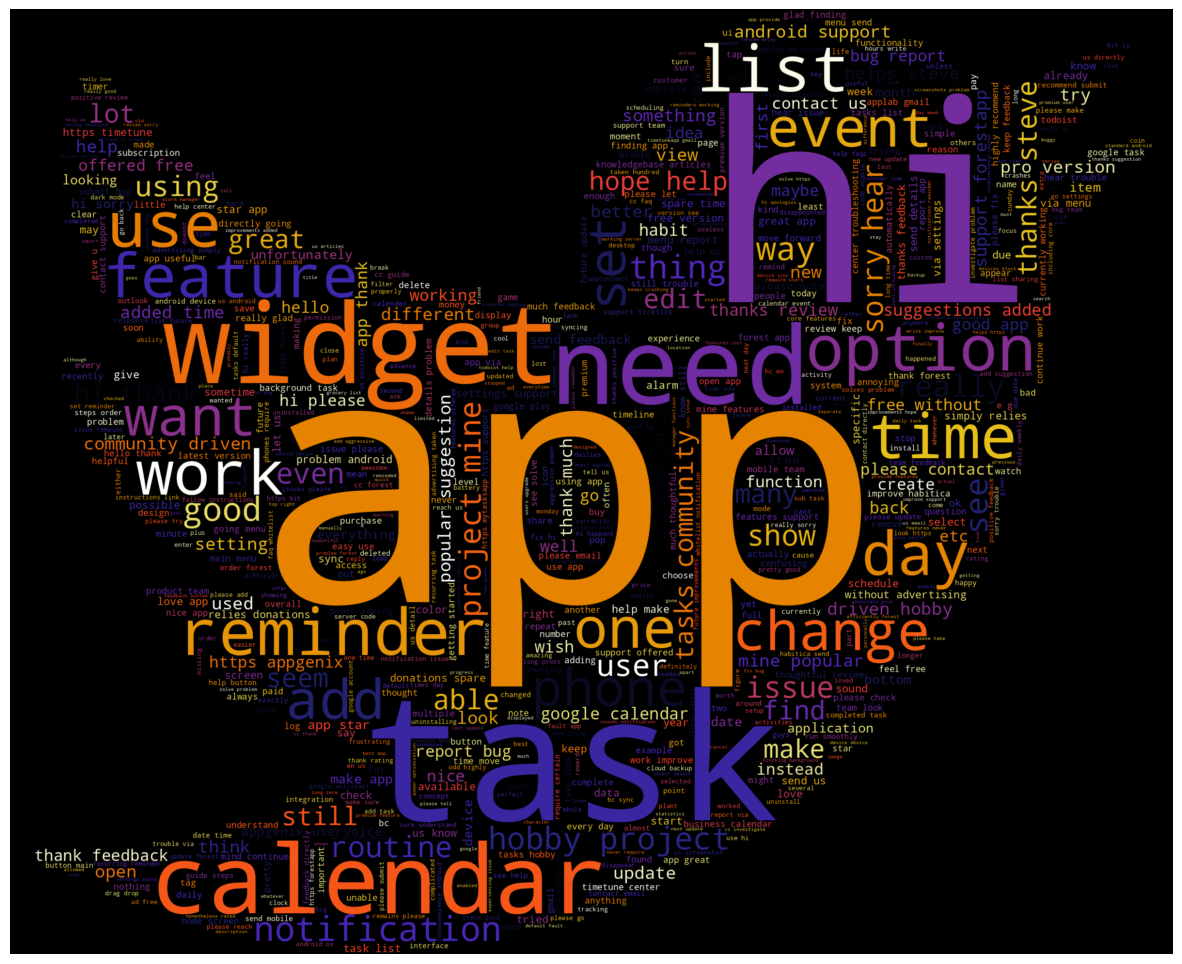

In [34]:
plt.figure(figsize=(15,15))
neutral_wordcloud=df[df["sentiment"]=="Neutral"]
neutral_text=" ".join(neutral_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS,background_color='black',max_words=800,colormap="CMRmap",mask=wordcloud_mask).generate(neutral_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [35]:
class_names = ['Negative', 'Positive', 'Neutral']

In [36]:
sentiment_map={"Negative":0,"Positive":1,"Neutral":2}
df["sentiment"]=df["sentiment"].replace(sentiment_map)

<ipython-input-36-2facacfdca45>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["sentiment"]=df["sentiment"].replace(sentiment_map)


In [37]:
df.head()


,text,sentiment
0,update getting response developer would change...,0
1,used fair amount time without problems suddenl...,0
2,app sucks used good update physically open clo...,0
3,seems ok basic recurring tasks need work actua...,0
4,absolutely worthless app runs prohibitively cl...,0


In [38]:
df['text_length'] = df['text'].apply(len)
average_text_length = df['text_length'].mean()
print(f"Average Text Length: {average_text_length:.2f}")

Average Text Length: 116.94


In [39]:
df.head()

,text,sentiment,text_length
0,update getting response developer would change...,0,479
1,used fair amount time without problems suddenl...,0,216
2,app sucks used good update physically open clo...,0,194
3,seems ok basic recurring tasks need work actua...,0,517
4,absolutely worthless app runs prohibitively cl...,0,471


In [40]:
df.drop(columns=["text_length"],axis=1,inplace=True)

### Load Bert Model


In [42]:
from transformers import BertModel,BertTokenizer
import torch

bert_model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [43]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [44]:
sample_text= "update getting response developer would change rating stars possible guys hide behind confusing opaque terms refuse budge annoyed money lost really terrible customer experience original careful signing free trial app happen go automatically charge full years subscription refuse refund terrible customer experience app ok according tos term agreed upon creating free trial days automatic charge plan unless cancel prior renewal date cancel subscription time charged per agreement"

In [45]:
tokens = bert_tokenizer.tokenize(sample_text)
token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
print("=======================================================================================")
print(f'Sentence: {sample_text}')
print("=======================================================================================")
print(f'Tokens: {tokens}')
print("=======================================================================================")
print(f'Token IDs: {token_ids}')
print("=======================================================================================")

Sentence: update getting response developer would change rating stars possible guys hide behind confusing opaque terms refuse budge annoyed money lost really terrible customer experience original careful signing free trial app happen go automatically charge full years subscription refuse refund terrible customer experience app ok according tos term agreed upon creating free trial days automatic charge plan unless cancel prior renewal date cancel subscription time charged per agreement
Tokens: ['update', 'getting', 'response', 'developer', 'would', 'change', 'rating', 'stars', 'possible', 'guys', 'hide', 'behind', 'confusing', 'opaque', 'terms', 'refuse', 'budge', 'annoyed', 'money', 'lost', 'really', 'terrible', 'customer', 'experience', 'original', 'careful', 'signing', 'free', 'trial', 'app', 'happen', 'go', 'automatically', 'charge', 'full', 'years', 'subscription', 'refuse', 'ref', '##und', 'terrible', 'customer', 'experience', 'app', 'ok', 'according', 'to', '##s', 'term', 'agreed

[SEP] - marker for ending of a sentence

In [46]:
bert_tokenizer.sep_token, bert_tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows it is classification

In [47]:
bert_tokenizer.cls_token, bert_tokenizer.cls_token_id

('[CLS]', 101)

In [48]:
bert_tokenizer.pad_token, bert_tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can
be encoded using the [UNK] (unknown) token:


In [49]:
bert_tokenizer.unk_token, bert_tokenizer.unk_token_id


('[UNK]', 100)

In [50]:
encoding = bert_tokenizer.encode_plus(
  sample_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt', # Return PyTorch tensors
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [51]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded or attention mask to a
length of 32

In [52]:
print(len(encoding['input_ids'][0]))
print("=======================================================================================")
print(encoding['input_ids'][0])

32
tensor([  101, 10651,  2893,  3433,  9722,  2052,  2689,  5790,  3340,  2825,
         4364,  5342,  2369, 16801, 28670,  3408, 10214, 24981, 11654,  2769,
         2439,  2428,  6659,  8013,  3325,  2434,  6176,  6608,  2489,  3979,
        10439,   102])


In [53]:
print(len(encoding['attention_mask'][0]))
print("=======================================================================================")
print(encoding['attention_mask'][0])

32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


We can inverse the tokenization to have a look at the special
tokens

In [54]:
bert_tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'update',
 'getting',
 'response',
 'developer',
 'would',
 'change',
 'rating',
 'stars',
 'possible',
 'guys',
 'hide',
 'behind',
 'confusing',
 'opaque',
 'terms',
 'refuse',
 'budge',
 'annoyed',
 'money',
 'lost',
 'really',
 'terrible',
 'customer',
 'experience',
 'original',
 'careful',
 'signing',
 'free',
 'trial',
 'app',
 '[SEP]']

### Choosing Sequence Length

> BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.

> Let’s store the token length of each review:


In [55]:
token_lens = []
for txt in df.text:
  tokens = bert_tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

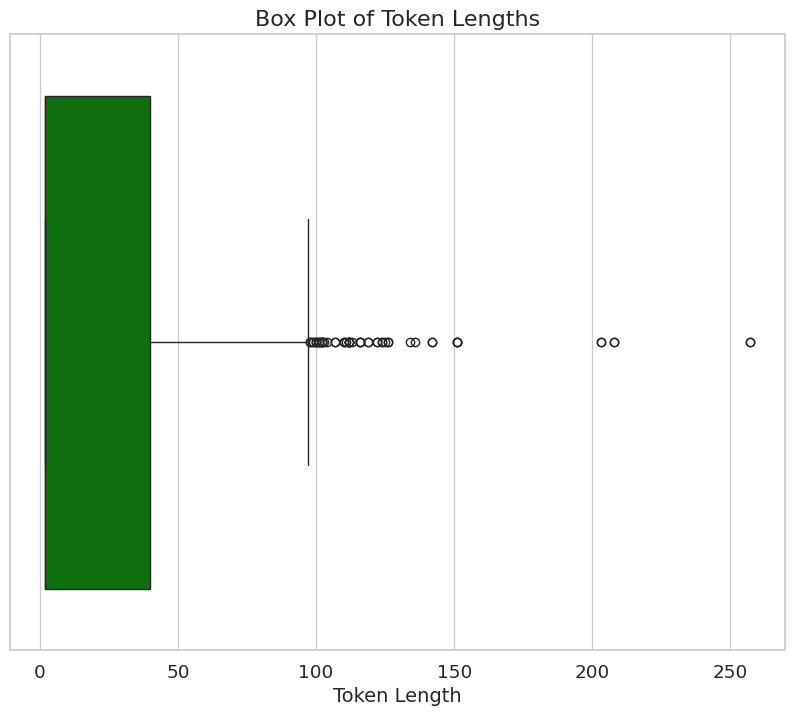

In [56]:
plt.figure(figsize=(10, 8))
sns.boxplot(x=token_lens, color='green')
plt.title('Box Plot of Token Lengths', fontsize=16)
plt.xlabel('Token Length', fontsize=14)
plt.show()


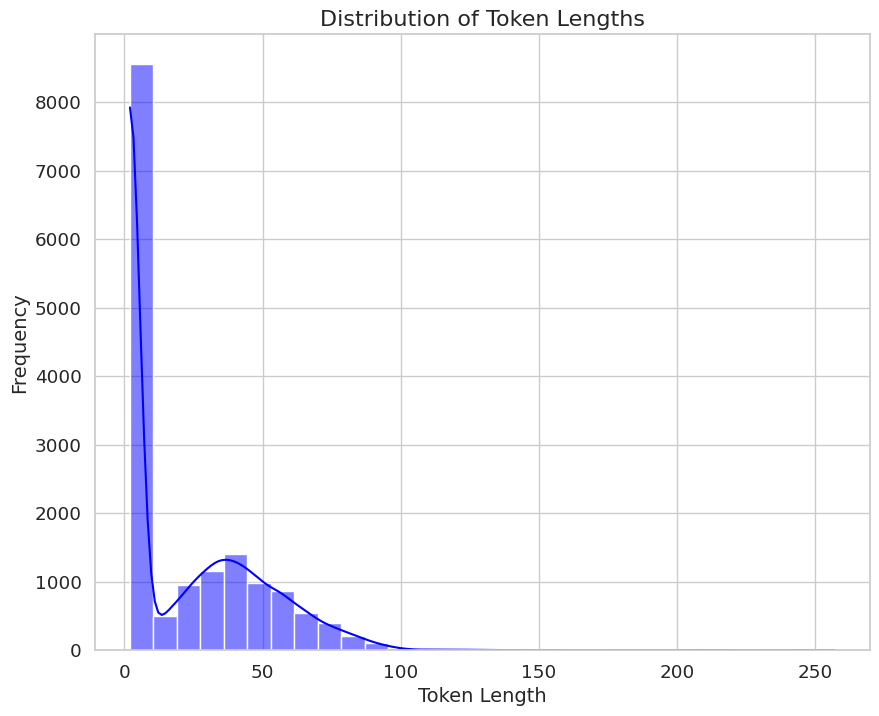

In [57]:
plt.figure(figsize=(10, 8))
sns.histplot(token_lens, bins=30, kde=True, color='blue')
plt.title('Distribution of Token Lengths', fontsize=16)
plt.xlabel('Token Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


Calculate min, max, and average

In [58]:
import statistics
min_length = min(token_lens)
max_length = max(token_lens)
avg_length = statistics.mean(token_lens)
print("==============================================================================")
print(f"Minimum Token Length: {min_length}")
print("==============================================================================")
print(f"Maximum Token Length: {max_length}")
print("==============================================================================")
print(f"Average Token Length: {avg_length:.2f}")
print("==============================================================================")

Minimum Token Length: 2
Maximum Token Length: 257
Average Token Length: 21.42


In [59]:
max_len=170

In [60]:
df.head()


,text,sentiment
0,update getting response developer would change...,0
1,used fair amount time without problems suddenl...,0
2,app sucks used good update physically open clo...,0
3,seems ok basic recurring tasks need work actua...,0
4,absolutely worthless app runs prohibitively cl...,0


Create Pytorch Dataset

In [61]:
from torch.utils.data import Dataset
import torch

class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self): # Corrected indentation so the function is defined for this class.
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
    review,
    add_special_tokens=True,
    max_length=self.max_len,
    padding='max_length', # Ensure padding to max_len
    return_token_type_ids=False,
    return_attention_mask=True,
    truncation=True, # Make sure long reviews are truncated to max_len
    return_tensors='pt', # Return as PyTorch tensors
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(), # Flatten to remove unnecessary dimensions
      'attention_mask': encoding['attention_mask'].flatten(), # Flatten the attention mask
      'targets': torch.tensor(target, dtype=torch.long) # Convert the target to a tensor
    }


The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it’ll be easier to evaluate the predictions from our model. Let’s split the data:

In [62]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [63]:
 df_train.shape, df_val.shape, df_test.shape

((11022, 2), (2362, 2), (2362, 2))

We also need to create a couple of data loaders. Here’s a helper function to do it:

In [64]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = GPReviewDataset(
  reviews=df.text.to_numpy(),
  targets=df.sentiment.to_numpy(),
  tokenizer=tokenizer,
  max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [65]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, bert_tokenizer,max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer,max_len, BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [66]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [67]:
print("##############################################################################")
print(data['input_ids'].shape)
print("##############################################################################")
print(data['attention_mask'].shape)
print("##############################################################################")
print(data['targets'].shape)
print("##############################################################################")

##############################################################################
torch.Size([16, 170])
##############################################################################
torch.Size([16, 170])
##############################################################################
torch.Size([16])
##############################################################################


try to use it on the encoding of our sample text

In [68]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

In [69]:
print(encoding)

{'input_ids': tensor([[  101, 10651,  2893,  3433,  9722,  2052,  2689,  5790,  3340,  2825,
          4364,  5342,  2369, 16801, 28670,  3408, 10214, 24981, 11654,  2769,
          2439,  2428,  6659,  8013,  3325,  2434,  6176,  6608,  2489,  3979,
         10439,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}


In [70]:
output =bert_model(input_ids=encoding['input_ids'],attention_mask=encoding['attention_mask'])
last_hidden_state=output.last_hidden_state

In [71]:
last_hidden_state.shape


torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the
feedforward-networks.

In [72]:
bert_model.config.hidden_size


768

In [73]:
pooled_output = last_hidden_state[:, 0]
pooled_output.shape

torch.Size([1, 768])

In [74]:
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("bert-base-uncased")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)


In [75]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We’ll move the example batch of our training data to the GPU

In [76]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 170])
torch.Size([16, 170])


To get the predicted probabilities from our trained model, we’ll apply the
softmax function to the outputs

In [77]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2992, 0.4391, 0.2617],
        [0.2578, 0.5284, 0.2139],
        [0.3007, 0.3344, 0.3649],
        [0.2850, 0.4599, 0.2550],
        [0.3701, 0.4031, 0.2268],
        [0.2542, 0.4595, 0.2863],
        [0.2601, 0.4488, 0.2911],
        [0.3591, 0.3297, 0.3113],
        [0.3201, 0.4120, 0.2678],
        [0.2459, 0.5144, 0.2397],
        [0.4029, 0.3870, 0.2101],
        [0.2681, 0.3379, 0.3940],
        [0.3006, 0.3957, 0.3037],
        [0.2922, 0.3848, 0.3230],
        [0.3333, 0.4333, 0.2334],
        [0.2493, 0.2646, 0.4861]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

To reproduce the training procedure from the BERT paper, we’ll use the AdamW
optimizer provided by Hugging Face. It corrects weight decay, so it’s similar to the original paper. We’ll also use a linear scheduler with no warmup steps:

In [81]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Set hyperparameters and optimizer
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5)

# Compute the total number of training steps
total_steps = len(train_data_loader) * EPOCHS

# Set up learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)


How do we come up with all hyperparameters? The BERT authors have some
recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We’re going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let’s continue with writing a helper function for training our model for one epoch

In [82]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in tqdm(data_loader, desc="Training", leave=False):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
    input_ids=input_ids,
    attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We’re avoiding exploding gradients by clipping the gradients of the model using clip_grad_norm_.

In [83]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in tqdm(data_loader, desc="Evaluating", leave=False):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [84]:
EPOCHS = 30
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

print("Training complete!")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


Epoch 1/30
----------


Training:   0%|          | 0/689 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train loss: 0.9798 | Train accuracy: 0.5193


Val loss: 0.9598 | Val accuracy: 0.5398

Epoch 2/30
----------


Train loss: 0.8758 | Train accuracy: 0.5928


Val loss: 0.8928 | Val accuracy: 0.5953

Epoch 3/30
----------


Train loss: 0.7666 | Train accuracy: 0.6527


Val loss: 0.9026 | Val accuracy: 0.6185

Epoch 4/30
----------


Train loss: 0.6771 | Train accuracy: 0.6906


Val loss: 0.9736 | Val accuracy: 0.6367

Epoch 5/30
----------


Train loss: 0.6372 | Train accuracy: 0.7073


Val loss: 1.0160 | Val accuracy: 0.6414

Epoch 6/30
----------


Train loss: 0.5963 | Train accuracy: 0.7199


Val loss: 1.0913 | Val accuracy: 0.6423

Epoch 7/30
----------


Train loss: 0.5839 | Train accuracy: 0.7242


Val loss: 1.1229 | Val accuracy: 0.6397

Epoch 8/30
----------


Train loss: 0.5707 | Train accuracy: 0.7279


Val loss: 1.1076 | Val accuracy: 0.6473

Epoch 9/30
----------


Train loss: 0.5640 | Train accuracy: 0.7297


Val loss: 1.1398 | Val accuracy: 0.6452

Epoch 10/30
----------


Train loss: 0.5600 | Train accuracy: 0.7309


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 11/30
----------


Train loss: 0.5577 | Train accuracy: 0.7305


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 12/30
----------


Train loss: 0.5583 | Train accuracy: 0.7312


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 13/30
----------


Train loss: 0.5569 | Train accuracy: 0.7316


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 14/30
----------


Train loss: 0.5565 | Train accuracy: 0.7315


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 15/30
----------


Train loss: 0.5614 | Train accuracy: 0.7305


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 16/30
----------


Train loss: 0.5557 | Train accuracy: 0.7317


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 17/30
----------


Train loss: 0.5579 | Train accuracy: 0.7311


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 18/30
----------


Train loss: 0.5563 | Train accuracy: 0.7312


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 19/30
----------


Train loss: 0.5568 | Train accuracy: 0.7314


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 20/30
----------


Train loss: 0.5574 | Train accuracy: 0.7309


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 21/30
----------


Train loss: 0.5587 | Train accuracy: 0.7305


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 22/30
----------


Train loss: 0.5597 | Train accuracy: 0.7303


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 23/30
----------


Train loss: 0.5569 | Train accuracy: 0.7315


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 24/30
----------


Train loss: 0.5576 | Train accuracy: 0.7314


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 25/30
----------


Train loss: 0.5577 | Train accuracy: 0.7308


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 26/30
----------


Train loss: 0.5570 | Train accuracy: 0.7313


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 27/30
----------


Train loss: 0.5594 | Train accuracy: 0.7306


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 28/30
----------


Train loss: 0.5577 | Train accuracy: 0.7314


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 29/30
----------


Train loss: 0.5608 | Train accuracy: 0.7304


Val loss: 1.1374 | Val accuracy: 0.6461

Epoch 30/30
----------


Train loss: 0.5572 | Train accuracy: 0.7313


Val loss: 1.1374 | Val accuracy: 0.6461

Training complete!
Best Validation Accuracy: 0.6473


### Training Metrics Visualization

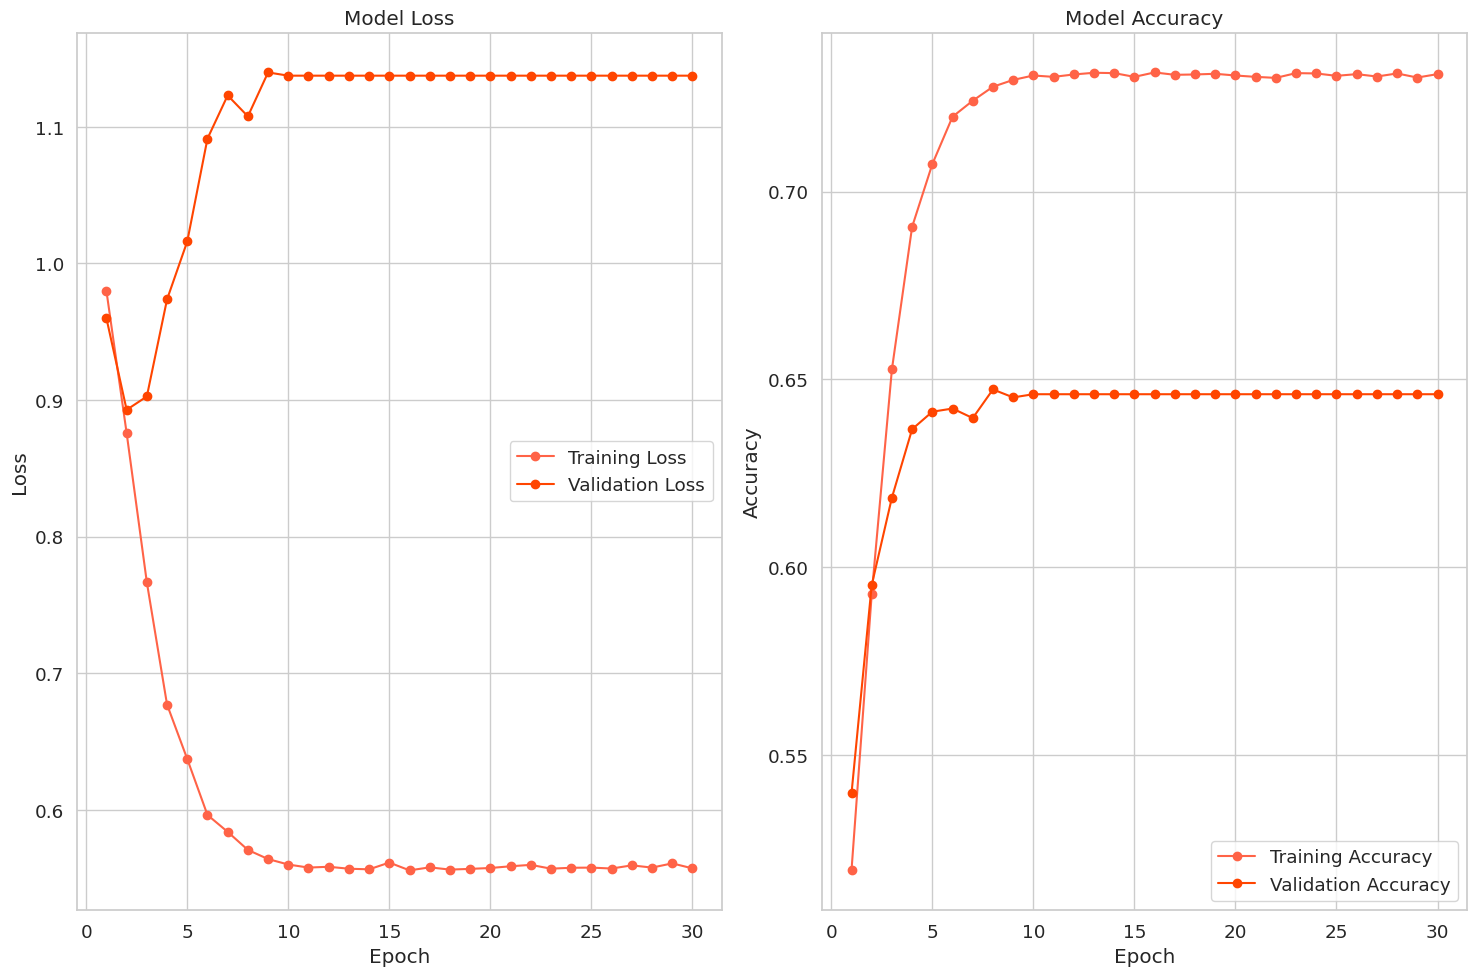

In [85]:
def plot_training_metrics(history):
  sns.set_style("whitegrid")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
  epochs = range(1, len(history['train_loss']) + 1)

  train_loss = [loss.cpu().numpy() if hasattr(loss, 'cpu') else loss for loss in history['train_loss']]
  val_loss = [loss.cpu().numpy() if hasattr(loss, 'cpu') else loss for loss in history['val_loss']]
  train_acc = [acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in history['train_acc']]
  val_acc = [acc.cpu().numpy() if hasattr(acc, 'cpu') else acc for acc in history['val_acc']]

  ax1.plot(epochs, train_loss, marker='o', label='Training Loss')
  ax1.plot(epochs, val_loss, marker='o', label='Validation Loss')
  ax1.set_title('Model Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  ax2.plot(epochs, train_acc, marker='o', label='Training Accuracy')
  ax2.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
  ax2.set_title('Model Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.tight_layout()
  plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
  plt.show()

plot_training_metrics(history)

### Evaluation

In [86]:
test_acc, _ = eval_model(
model,
test_data_loader,
loss_fn,
device,
len(df_test)
)

test_acc.item()

0.6469093988145639

In [87]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [88]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

###  Classification Report


In [89]:
from sklearn.metrics import (
confusion_matrix,
classification_report,
roc_auc_score,
roc_curve,
accuracy_score,
)

print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    Negative       0.88      0.49      0.63       767
    Positive       0.55      0.95      0.70       864
     Neutral       0.74      0.45      0.56       731

    accuracy                           0.65      2362
   macro avg       0.72      0.63      0.63      2362
weighted avg       0.72      0.65      0.63      2362



###  Confusion Matrix

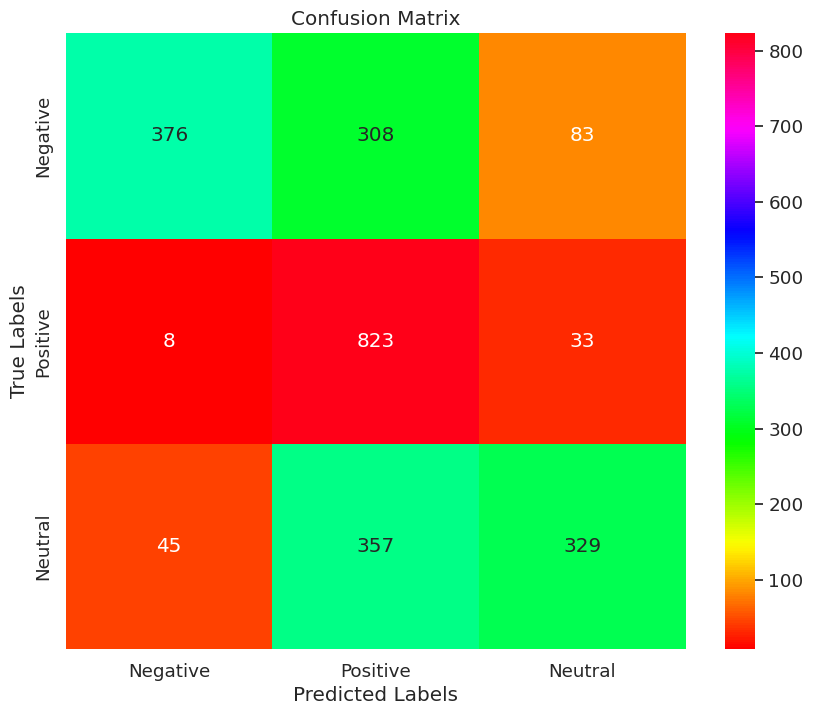

In [90]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='hsv', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Roc Curve

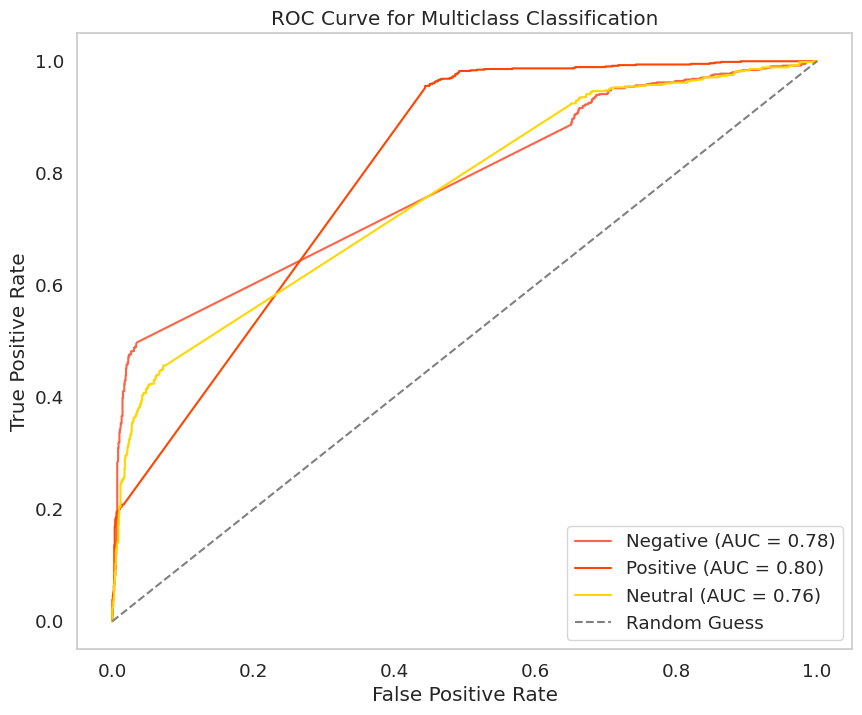

In [91]:
plt.figure(figsize=(10,8))

class_names = ['Negative', 'Positive', 'Neutral']
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

for i, class_name in enumerate(class_names):
  if np.sum(y_test_binarized[:, i]) > 0 and np.sum(1 - y_test_binarized[:, i]) > 0:
    fpr, tpr, thresholds = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")
  else:
    print(f"Skipping {class_name} because only one class is present in y_test.")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass Classification")
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Precision Recall Curve

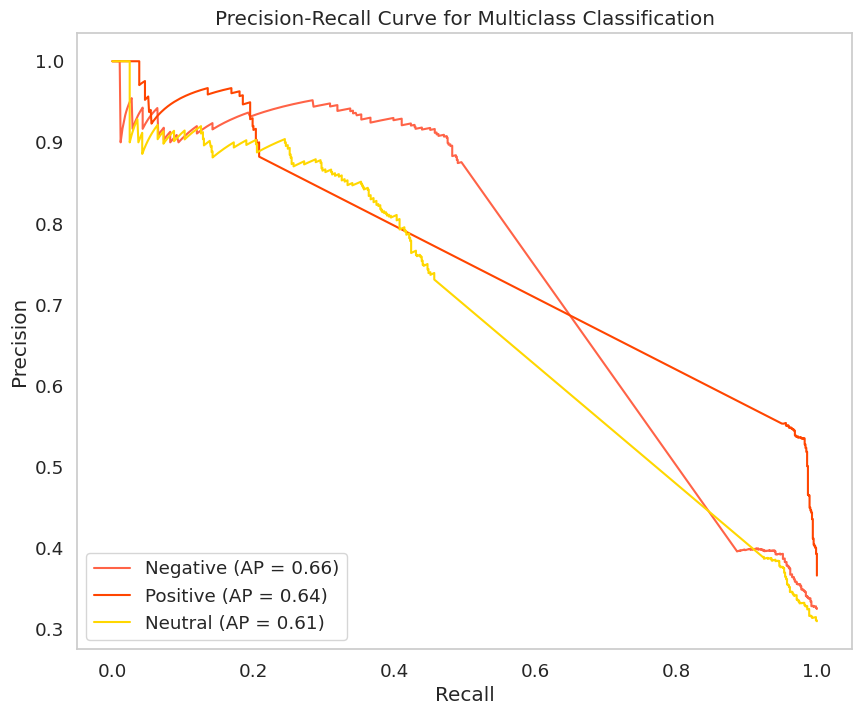

In [92]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10,8))

class_names = ['Negative', 'Positive', 'Neutral']
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))

for i, class_name in enumerate(class_names):
  if np.sum(y_test_binarized[:, i]) > 0 and np.sum(1 - y_test_binarized[:, i]) > 0:
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_test_binarized[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{class_name} (AP = {avg_precision:.2f})")
  else:
    print(f"Skipping {class_name} because only one class is present in y_test.")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multiclass Classification")
plt.legend(loc="lower left")
plt.grid()
plt.show()

### Roc Auc Score

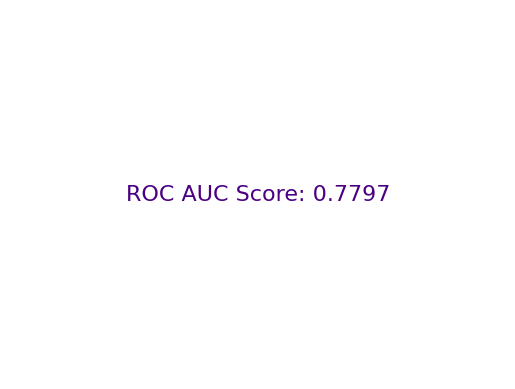

In [93]:
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
plt.plot([])
plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center', color="indigo")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

### Log Loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


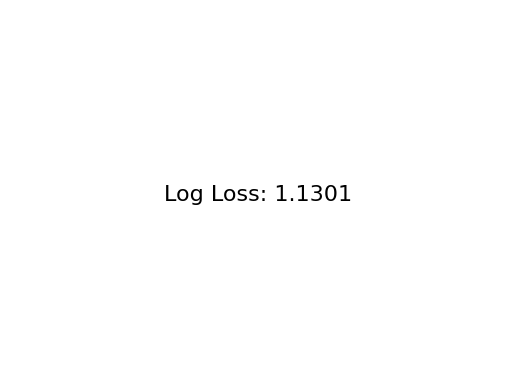

In [94]:
from sklearn.metrics import log_loss
classes = [0, 1, 2]
logarithm_loss = log_loss(y_test, y_pred_probs, labels=classes)
plt.plot([])
plt.text(0, 0, f'Log Loss: {logarithm_loss:.4f}', fontsize=16, ha='center', va='center', color="black")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

### Kappa Score


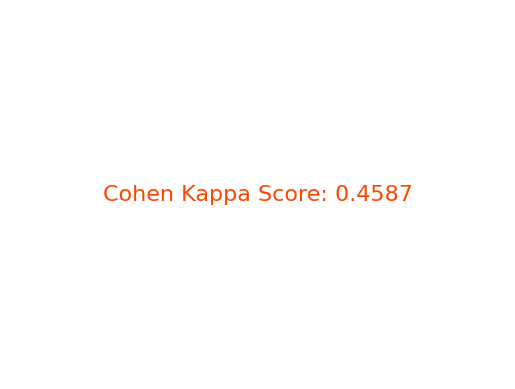

In [95]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test,y_pred)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="orangered")
plt.axis('off')
# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)
plt.show()

### matthews_corrcoef

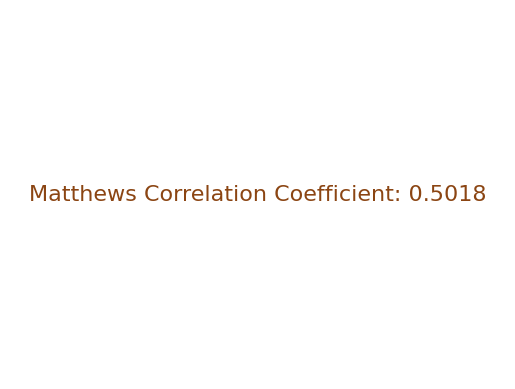

In [103]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test,y_pred)

# Create a plot and display the MCC value as text
plt.plot([])
plt.text(0,0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=16, ha='center', va='center',color="saddlebrown")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)
plt.show()

### Model Prediction

In [104]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names': class_names,'values': y_pred_probs[idx]})

In [105]:
from textwrap import wrap
print("==============================================================================")
print("\n".join(wrap(review_text)))
print("==============================================================================")
print(f'True sentiment: {class_names[true_sentiment]}')
print("==============================================================================")


True sentiment: Positive


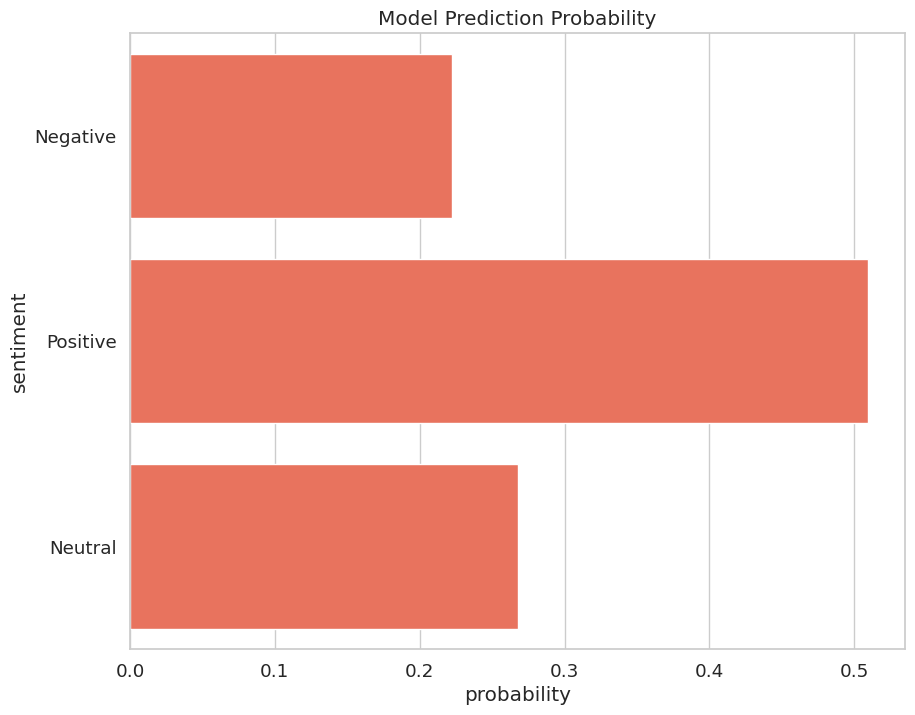

In [106]:
plt.figure(figsize=(10,8))
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.title("Model Prediction Probability")
plt.show()

In [107]:
review_text = "Every day brings a new opportunity to overcome challenges, learn from experiences, and grow stronger, as we continuously work towards becoming the best version of ourselves, embracing both successes and setbacks as stepping stones toward a brighter future"


In [108]:
encoded_review = bert_tokenizer.encode_plus(
review_text,
max_length=max_len,
add_special_tokens=True,
return_token_type_ids=False,
pad_to_max_length=True,
return_attention_mask=True,
return_tensors='pt',
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [109]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print("=======================================================================================")
print(f'Review text: {review_text}')
print("=======================================================================================")
print(f'Sentiment : {class_names[prediction]}')
print("=======================================================================================")

Review text: Every day brings a new opportunity to overcome challenges, learn from experiences, and grow stronger, as we continuously work towards becoming the best version of ourselves, embracing both successes and setbacks as stepping stones toward a brighter future
Sentiment : Positive
